<a href="https://colab.research.google.com/github/ochekroun/labs/blob/master/IFAGE_Cours_3_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 Entraînement par transfert - Reconnaitre la race de chiens

Dans ce notebook, nous allons entraîner un modèle pour reconnaître la race de chien à partir d'images. Nous utiliserons du "transfer learning" à partir de modèles EfficientNet.

In [ ]:
!pip install -U keras

Installation de  `wandb` et connection au compte :

In [ ]:
!pip install -U wandb
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()

wandb: Currently logged in as: masterscrat (nyxai). Use `wandb login --relogin` to force relogin


True

## 📚 Jeu de donnée

On utilise le jeu de données *Stanford Dogs* qui contient plus de 20k images de chiens de 120 races différentes.

Plus d'informations : http://vision.stanford.edu/aditya86/ImageNetDogs/main.html

Pour le télécharger on utilise `tfds`. L'identifiant du jeu de données est `stanford_dogs`:

https://www.tensorflow.org/datasets/catalog/stanford_dogs

In [ ]:
import tensorflow_datasets as tfds

dataset_name = "stanford_dogs"

(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)

On obtient en plus des images des métadonnées, comme le lien vers la page du jeu de donnée, sa license etc

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_dir='/root/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
            'bbox': B

On récupère le nombre de classe, qui sera utile pour la suite :

In [ ]:
NUM_CLASSES = ds_info.features["label"].num_classes
print(f"Nombre de classes (races de chien): {NUM_CLASSES}")

Nombre de classes (races de chien): 120


On peut aussi obtenir l'intitulé de chaque classe à partir de son index:

In [ ]:
for class_idx in range(NUM_CLASSES):
  print(f"Index {class_idx}: {ds_info.features['label'].int2str(class_idx)}")

Index 0: n02085620-chihuahua
Index 1: n02085782-japanese_spaniel
Index 2: n02085936-maltese_dog
Index 3: n02086079-pekinese
Index 4: n02086240-shih-tzu
Index 5: n02086646-blenheim_spaniel
Index 6: n02086910-papillon
Index 7: n02087046-toy_terrier
Index 8: n02087394-rhodesian_ridgeback
Index 9: n02088094-afghan_hound
Index 10: n02088238-basset
Index 11: n02088364-beagle
Index 12: n02088466-bloodhound
Index 13: n02088632-bluetick
Index 14: n02089078-black-and-tan_coonhound
Index 15: n02089867-walker_hound
Index 16: n02089973-english_foxhound
Index 17: n02090379-redbone
Index 18: n02090622-borzoi
Index 19: n02090721-irish_wolfhound
Index 20: n02091032-italian_greyhound
Index 21: n02091134-whippet
Index 22: n02091244-ibizan_hound
Index 23: n02091467-norwegian_elkhound
Index 24: n02091635-otterhound
Index 25: n02091831-saluki
Index 26: n02092002-scottish_deerhound
Index 27: n02092339-weimaraner
Index 28: n02093256-staffordshire_bullterrier
Index 29: n02093428-american_staffordshire_terrier


## Regardons à quoi ressemble les données...

On commence par redimensionner les images à la bonne taille.

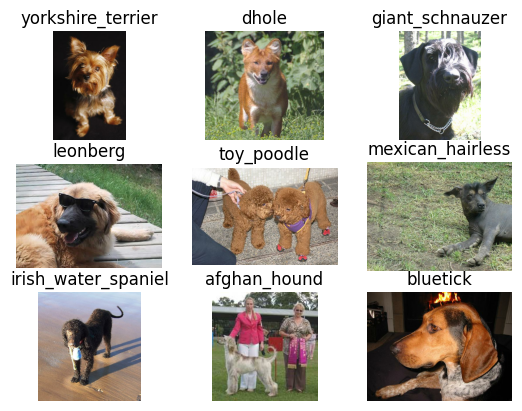

In [ ]:
import matplotlib.pyplot as plt

label_info = ds_info.features["label"]
def format_label(label):
    # on retire le préfixe du nom de chaque classe
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

## Redimensionnons les données

La taille des images utilisée pour l'entraînement doit correspondre à la taille attendue par le modèle !

In [ ]:
IMG_SIZE = 224

In [ ]:
import tensorflow as tf

# on redimensionne les images à la bonne taille
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [ ]:
from keras.utils import to_categorical

def input_preprocess_train(image, label):
    # Augmentation des données ?
    # image = img_augmentation(image)
    # Encodage "One-hot"
    label = to_categorical(label, num_classes=NUM_CLASSES)
    return image, label

def input_preprocess_test(image, label):
    # Encodage "One-hot"
    label = to_categorical(label, num_classes=NUM_CLASSES)
    return image, label

BATCH_SIZE = 64
ds_train_preprocessed = ds_train.map(input_preprocess_train)
ds_train_batches = ds_train_preprocessed.batch(batch_size=BATCH_SIZE)

ds_test_preprocessed = ds_test.map(input_preprocess_test)
ds_test_batches = ds_test_preprocessed.batch(batch_size=BATCH_SIZE)

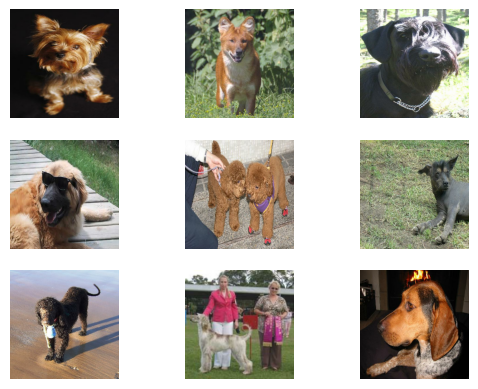

In [ ]:
for i, (image, label) in enumerate(ds_train_preprocessed.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

## Et si on entrainait EfficientNet de zéro ? 🤔

On utilise un modèle pré-entrainé EfficientNet (https://blog.research.google/2019/05/efficientnet-improving-accuracy-and.html)

Commençons par utiliser le modèle EfficientNet le plus petit: `EfficientNetB0`.

| Model | Résolution|Paramètres|
|----------------|-----|----|
| EfficientNetB0 | 224 |5.3M|
| EfficientNetB1 | 240 |7.8M|
| EfficientNetB2 | 260 |9.2M|
| EfficientNetB3 | 300 |12M|
| EfficientNetB4 | 380 |19M|
| EfficientNetB5 | 456 |30M|
| EfficientNetB6 | 528 |43M|
| EfficientNetB7 | 600 |66M|

In [ ]:
from keras.applications import EfficientNetB0
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
run = wandb.init(
    project = "keras-dogs"
)

hist = model.fit(
    ds_train_batches,
    epochs=3,
    validation_data=ds_test_batches
)

run.finish()

Epoch 1/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 289s 846ms/step - accuracy: 0.0107 - loss: 5.0852 - val_accuracy: 0.0139 - val_loss: 4.9398
Epoch 2/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 71s 377ms/step - accuracy: 0.0237 - loss: 4.6034 - val_accuracy: 0.0164 - val_loss: 5.1944
Epoch 3/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 71s 377ms/step - accuracy: 0.0410 - loss: 4.3587 - val_accuracy: 0.0435 - val_loss: 4.3256


Le modèle est trop gros pour notre jeu de donnée et pour nos capacités de calcul, l'apprentissage de zéro n'est pas faisable dans notre situation !

## Apprentissage par transfert

On fait de la "chirurgie" pour modifier le modèle EfficientNet existant afin de n'entraîner que les dernières couches.

In [ ]:
import keras
from keras import layers

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # On retire les dernières couches avec "include_top=False"
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # "Glace" the paramètres pré-entrainés
    model.trainable = False

    # On rajoute les couches retirées - ces couches sont entrainables !
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)

    # On peut ajuster le ratio de neurones désactivés pour la couche Dropout
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    # Compile le nouveau modèle
    model = keras.Model(inputs, outputs, name="EfficientNet")

    # On augmente le learning rate du défaut 0.001 à 0.01
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

In [ ]:
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
run = wandb.init(
    project = "keras-dogs"
)

model.fit(
    ds_train_batches,
    epochs=3,
    validation_data=ds_test_batches,
    callbacks = [WandbMetricsLogger()]
)

run.finish()

Epoch 1/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5595 - loss: 1.8063

wandb: ERROR Unable to log learning rate.


188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 341ms/step - accuracy: 0.5600 - loss: 1.8034 - val_accuracy: 0.7626 - val_loss: 0.8717
Epoch 2/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.8242 - loss: 0.5713 - val_accuracy: 0.7662 - val_loss: 0.8994
Epoch 3/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - accuracy: 0.8702 - loss: 0.4019 - val_accuracy: 0.7679 - val_loss: 0.9712


epoch/accuracy,▁▆█
epoch/epoch,▁▅█
epoch/loss,█▂▁
epoch/val_accuracy,▁▆█
epoch/val_loss,▁▃█
epoch/accuracy,0.87133
epoch/epoch,2
epoch/loss,0.39657
epoch/val_accuracy,0.76795
epoch/val_loss,0.9712


## Léger apprentissage complet après l'apprentissage par transfer

On fait la chirurgie inverse sur le modèle précédent, pour le rendre de nouveau complètement entraînable.

In [ ]:
def unfreeze_model(model):
    # On rends entrainable les derniers 20 layers (sauf ceux de BatchNormalization)
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

In [ ]:
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 1,275,304 (4.86 MB)

 Non-trainable params: 2,927,987 (11.17 MB)

In [ ]:
run = wandb.init(
    project = "keras-dogs"
)

hist = model.fit(
    ds_train_batches,
    epochs=3,
    validation_data=ds_test_batches
)

run.finish()